# City Home Value Forecasting using LSTM
This notebook loads time series data for city home values, performs data cleaning and preprocessing, engineers features, structures the data into sequences for an LSTM model, and then trains and evaluates the model for time series forecasting.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set global plotting style
plt.style.use('ggplot')

2025-11-05 13:51:52.148753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 13:51:52.373640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 13:51:53.815032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## PART 1: DATA LOADING AND PREPROCESSING

In [2]:
# Step 1: Load the dataset (Ensure 'city_time_series.csv' is in the same directory)
try:
    df = pd.read_csv('/home/hardik/Desktop/python_intern/archive/City_time_series.csv')
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'city_time_series.csv' not found. Please ensure the file is in the correct path.")
    df = pd.DataFrame()

if not df.empty:
    # Step 2: Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Step 3: Drop rows with missing or invalid Date
    df = df.dropna(subset=['Date'])

    # Step 4: Sort by city (RegionName) and Date
    df = df.sort_values(['RegionName', 'Date']).reset_index(drop=True)

    # Step 5: Check for missing values
    missing_summary = df.isnull().sum().sort_values(ascending=False)
    print('\nTop missing columns:')
    print(missing_summary.head(10))

    # Step 6: Drop columns with >60% missing data
    df = df.dropna(axis=1, thresh=0.6 * len(df))
    missing_summary = df.isnull().sum().sort_values(ascending=False)
    print('\nTop missing columns after cleanup:')
    print(missing_summary.head(10))

    # Step 7: Forward fill missing numeric values per city
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df.groupby('RegionName')[numeric_cols].transform(lambda x: x.ffill().bfill())

    # Print dataset info
    print("\n=== Dataset Info ===")
    df.info()

    # Basic statistics
    print("\n=== Summary Statistics ===")
    print(df.describe())

Dataset shape: (3762566, 81)

Top missing columns:
PctOfHomesSellingForGain_AllHomes          3762365
PctOfHomesSellingForLoss_AllHomes          3762365
MedianRentalPrice_5BedroomOrMore           3761440
MedianRentalPricePerSqft_5BedroomOrMore    3761398
MedianRentalPricePerSqft_DuplexTriplex     3756962
MedianListingPrice_1Bedroom                3756072
MedianListingPricePerSqft_DuplexTriplex    3754982
MedianListingPricePerSqft_1Bedroom         3754896
MedianListingPrice_DuplexTriplex           3754387
MedianRentalPrice_DuplexTriplex            3753260
dtype: int64

Top missing columns after cleanup:
PctOfHomesDecreasingInValues_AllHomes    1408159
PctOfHomesIncreasingInValues_AllHomes    1408159
ZHVI_3bedroom                            1221931
ZHVI_BottomTier                          1163169
ZHVIPerSqft_AllHomes                      809121
ZHVI_SingleFamilyResidence                687235
ZHVI_MiddleTier                           685018
ZHVI_AllHomes                             67917

## PART 2: EXPLORATORY DATA ANALYSIS (EDA)

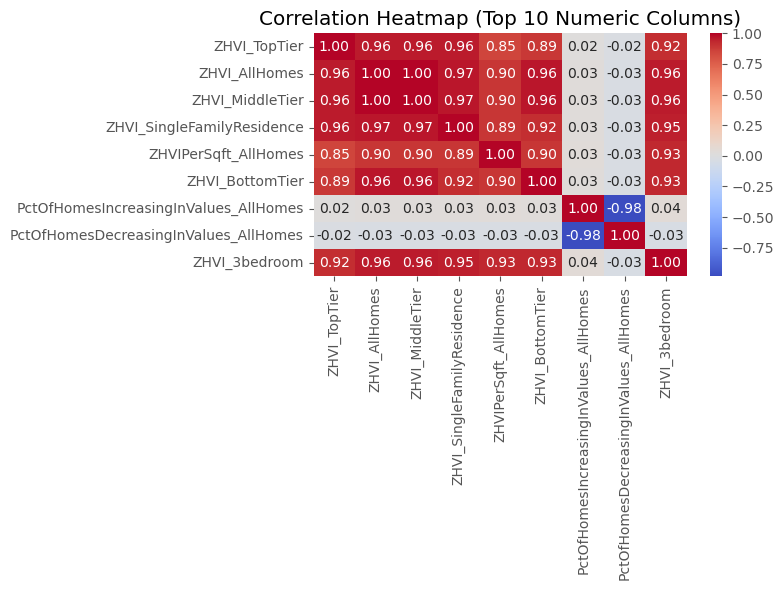

In [3]:
# Correlation Heatmap
if not df.empty:
    numeric_df = df.select_dtypes(include='number')
    # Select top 10 columns with least NaNs (after initial cleanup)
    top_cols = numeric_df.isnull().sum().sort_values().index[:10]
    corr = numeric_df[top_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap (Top 10 Numeric Columns)")
    plt.tight_layout()
    plt.show()

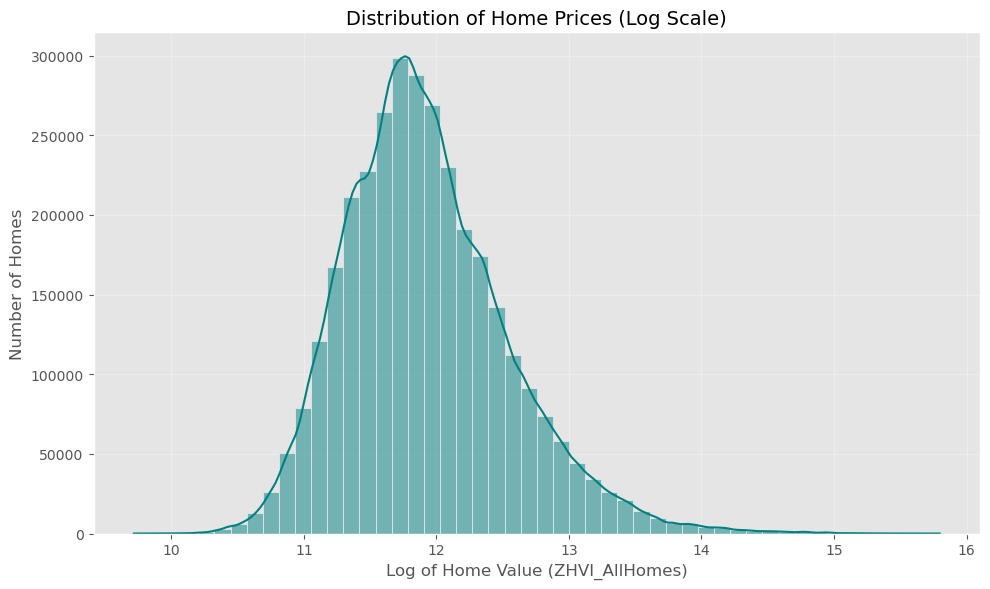

In [4]:
# Distribution of Home Prices (Log Scale)
if not df.empty and 'ZHVI_AllHomes' in df.columns:
    data = df['ZHVI_AllHomes'].dropna()
    data = data[data > 0]

    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(data), bins=50, kde=True, color='teal')
    plt.title("Distribution of Home Prices (Log Scale)", fontsize=14)
    plt.xlabel("Log of Home Value (ZHVI_AllHomes)", fontsize=12)
    plt.ylabel("Number of Homes", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## PART 3: FEATURE ENGINEERING AND SCALING

In [5]:
# Define features and target
if not df.empty:
    target_col = 'ZHVI_AllHomes'
    feature_cols = [col for col in df.select_dtypes(include=np.number).columns 
                    if col != target_col and col != 'RegionID' and col != 'SizeRank']
    all_cols = feature_cols + [target_col]

    print("\n=== Input (Feature) Columns ===")
    print(feature_cols)
    print("\n=== Target Column ===")
    print(target_col)

    # Forward-fill and backward-fill per city (final cleanup before scaling)
    df[all_cols] = df.groupby('RegionName')[all_cols].transform(lambda x: x.ffill().bfill())

    # Drop any remaining NaNs
    df = df.dropna(subset=all_cols)

    # Scale features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    if not df.empty and not df[feature_cols].empty:
        X_scaled = scaler_X.fit_transform(df[feature_cols])
        y_scaled = scaler_y.fit_transform(df[[target_col]])

        print(f"\nNaN check - X: {np.isnan(X_scaled).sum()}, y: {np.isnan(y_scaled).sum()}")
    else:
        X_scaled = np.array([])
        y_scaled = np.array([])
        print("DataFrame is empty after final NaN cleanup.")


=== Input (Feature) Columns ===
['ZHVIPerSqft_AllHomes', 'PctOfHomesDecreasingInValues_AllHomes', 'PctOfHomesIncreasingInValues_AllHomes', 'ZHVI_3bedroom', 'ZHVI_BottomTier', 'ZHVI_MiddleTier', 'ZHVI_SingleFamilyResidence', 'ZHVI_TopTier']

=== Target Column ===
ZHVI_AllHomes

NaN check - X: 0, y: 0


## PART 4: CREATE SEQUENCES FOR LSTM

In [6]:
# Define the number of past timesteps (months) to look back
timesteps = 12
X_lstm, y_lstm = [], []

if X_scaled.size > 0 and len(X_scaled) > timesteps:
    for i in range(timesteps, len(X_scaled)):
        seq_X = X_scaled[i-timesteps:i]
        seq_y = y_scaled[i]
        # Basic check to avoid NaN sequences (although cleaning was performed)
        if not (np.isnan(seq_X).any() or np.isnan(seq_y).any()):
            X_lstm.append(seq_X)
            y_lstm.append(seq_y)

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    # Train-test split (80% train, 20% test)
    split_idx = int(0.8 * len(X_lstm))
    X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
    y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]

    print("\n=== Data Split ===")
    print(f"Total training samples: {len(X_train)}")
    print(f"Total test samples: {len(X_test)}")
    print(f"Training data shape: {X_train.shape}, Target shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}, Target shape: {y_test.shape}")
else:
    print("Not enough data to create time sequences with current settings.")
    X_train, X_test, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])


=== Data Split ===
Total training samples: 1582556
Total test samples: 395639
Training data shape: (1582556, 12, 8), Target shape: (1582556, 1)
Test data shape: (395639, 12, 8), Target shape: (395639, 1)


## PART 5: BUILD AND TRAIN LSTM MODEL

In [7]:
if X_train.size > 0:
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    print("\n=== Model Summary ===")
    model.summary()

    # Train the model
    print("\n=== Model Training ===")
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test, y_test),
        verbose=1
    )
else:
    print("Skipping model build and train: Training data is empty.")


=== Model Summary ===


/usr/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,753 (73.25 KB)

 Trainable params: 18,753 (73.25 KB)

 Non-trainable params: 0 (0.00 B)


=== Model Training ===
Epoch 1/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - loss: 2.9930e-05 - val_loss: 8.8656e-06
Epoch 2/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - loss: 2.1653e-05 - val_loss: 8.0056e-06
Epoch 3/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step - loss: 2.0895e-05 - val_loss: 8.4918e-06
Epoch 4/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 105s 4ms/step - loss: 1.9850e-05 - val_loss: 7.1278e-06
Epoch 5/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 1.9269e-05 - val_loss: 7.6063e-06
Epoch 6/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - loss: 1.9418e-05 - val_loss: 7.0848e-06
Epoch 7/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - loss: 1.9299e-05 - val_loss: 7.0999e-06
Epoch 8/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - loss: 1.9307e-05 - val_loss: 7.8922e-06
Epoch 9/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step - loss: 1.8095e-05 - val_loss: 7.7689e-06
Epoch 10/10
24728/24728 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - loss: 1.8330e-05 

## PART 6: EVALUATE MODEL (Full Test Set)

In [8]:
if X_test.size > 0:
    # Predict on full test set
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    r2 = r2_score(y_test_actual, y_pred)

    print(f"\n=== Full Test Set Performance ===")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R²: {r2:.4f}")
else:
    print("Skipping full test evaluation: Test data is empty.")

12364/12364 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step

=== Full Test Set Performance ===
Test RMSE: 20384.23
Test R²: 0.9861


## PART 7: DETAILED EVALUATION ON SAMPLE

In [9]:
if X_test.size > 0:
    # Narrow down test data to a maximum of 200 rows for detailed analysis
    sample_size = min(200, len(X_test))
    X_test_small = X_test[:sample_size]
    y_test_small = y_test[:sample_size]

    y_pred_scaled_small = model.predict(X_test_small)
    y_pred_small = scaler_y.inverse_transform(y_pred_scaled_small)
    y_test_actual_small = scaler_y.inverse_transform(y_test_small)

    # Create comparison dataframe
    comparison = pd.DataFrame({
        "Actual_ZHVI_AllHomes": y_test_actual_small.flatten(),
        "Predicted_ZHVI_AllHomes": y_pred_small.flatten()
    })

    comparison["Absolute_Error"] = abs(
        comparison["Actual_ZHVI_AllHomes"] - comparison["Predicted_ZHVI_AllHomes"]
    )
    comparison["% Error"] = (
        100 * comparison["Absolute_Error"] / comparison["Actual_ZHVI_AllHomes"]
    )

    print("\n=== Head of Actual vs Predicted (Top 10) ===")
    print(comparison.head(10))

    # Calculate metrics on sample
    rmse_small = np.sqrt(mean_squared_error(y_test_actual_small, y_pred_small))
    mae_small = mean_absolute_error(y_test_actual_small, y_pred_small)
    r2_small = r2_score(y_test_actual_small, y_pred_small)
    accuracy = 100 - comparison["% Error"].mean()

    print("\n=== Prediction Performance on Sample ===")
    print(f"RMSE: {rmse_small:.2f}")
    print(f"MAE: {mae_small:.2f}")
    print(f"R²: {r2_small:.4f}")
    print(f"Approx. Prediction Accuracy: {accuracy:.2f}%")

    # Save comparison
    comparison.to_csv("prediction_comparison.csv", index=False)
    print("\nSaved comparison results to 'prediction_comparison.csv'")
else:
    print("Skipping detailed evaluation: Test data is empty.")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

=== Head of Actual vs Predicted (Top 10) ===
   Actual_ZHVI_AllHomes  Predicted_ZHVI_AllHomes  Absolute_Error   % Error
0              155500.0            154700.421875      799.578125  0.514198
1              155200.0            153251.171875     1948.828125  1.255688
2              155400.0            152662.765625     2737.234375  1.761412
3              154800.0            152854.906250     1945.093750  1.256521
4              153600.0            152132.625000     1467.375000  0.955322
5              152600.0            150837.343750     1762.656250  1.155083
6              151800.0            149617.625000     2182.375000  1.437665
7              151300.0            148635.765625     2664.234375  1.760895
8              151200.0            147999.546875     3200.453125  2.116702
9              151500.0            147593.343750     3906.656250  2.578651

=== Prediction Performance on Sample ===
RMSE: 5175.26
MAE: 2340.47
R²: 0.9640
Approx. Pre

## PART 8: VISUALIZATION

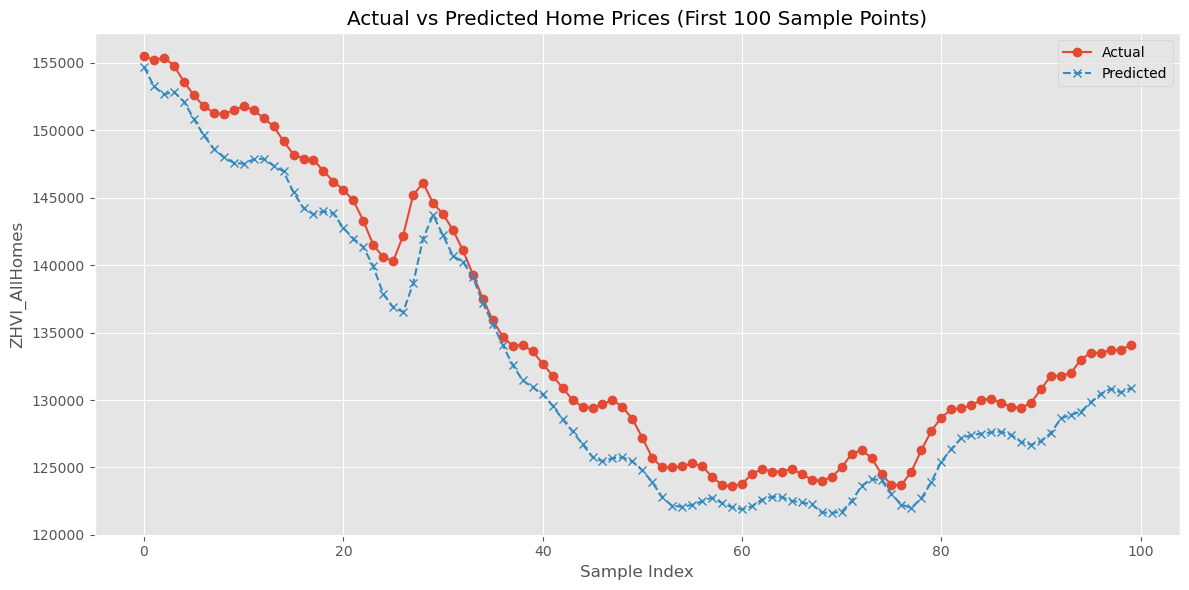

In [10]:
if 'comparison' in locals() and not comparison.empty:
    # Plot actual vs predicted (first 100 samples of the small test set)
    plot_samples = min(100, len(comparison))
    plt.figure(figsize=(12, 6))
    plt.plot(comparison["Actual_ZHVI_AllHomes"].head(plot_samples), label="Actual", marker='o', linestyle='-')
    plt.plot(comparison["Predicted_ZHVI_AllHomes"].head(plot_samples), label="Predicted", marker='x', linestyle='--')
    plt.title("Actual vs Predicted Home Prices (First 100 Sample Points)")
    plt.xlabel("Sample Index")
    plt.ylabel("ZHVI_AllHomes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization: Comparison data is not available.")

## PART 9 & 10: SAVE AND TEST MODEL

In [11]:
if 'model' in locals():
    # Save in native Keras format
    model.save("lstm_model.keras")
    print("\nModel saved as 'lstm_model.keras'")

    # Load and test saved model
    print("\n=== Testing Model Load ===")
    loaded_model = load_model("lstm_model.keras")
    print("Model loaded successfully!")

    # Quick prediction test
    if X_test.size > 0:
        test_pred = loaded_model.predict(X_test_small[:10])
        print(f"Sample prediction shape: {test_pred.shape}")
    else:
        print("Cannot perform quick prediction test: Test data is empty.")
else:
    print("Skipping model save/load: Model object not created.")


Model saved as 'lstm_model.keras'

=== Testing Model Load ===
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Sample prediction shape: (10, 1)
